In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2+abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    print('??')
    MODEL.optimize()
    print('??')
    return np.array(MODEL.x)

In [27]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv

class Model(nn.Module):
    """Template for fully connected neural network for scalar approximation.
    """
    def __init__(self, 
                 input_size=1, 
                 hidden_size=2,
                 n_layers=4,
                 activation='ReLU',
                 p=0.0,
                ):
        super(Model, self).__init__()
        
        self.n_layers = n_layers
        
        if self.n_layers == 1:
            self.layers = [nn.Linear(input_size, 1)]
        else:
            size  = [input_size] + [hidden_size,] * (self.n_layers-1) + [1]
            self.layers = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers = nn.ModuleList(self.layers)
        
        # dropout layer
        self.dropout = nn.Dropout(p=p)
        
        # activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception('{} not an available activation'.format(activation))
            
    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.dropout(self.activation(self.layers[i](x)))
        x = self.layers[-1](x)
        return x


In [28]:
import numpy as np
import abc
from tqdm import tqdm

class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor
        
        # train approximator only every few rounds
        self.train_every = train_every
        self.best_recommended_reward =-200
        self.best_recommended_action =np.array([1]*args.card+[0]*(self.bandit.n_features-args.card))
        self.rewards_list=[]
        self.best_sample_rewards_list=[]
        self.feasi=[]
        # throttle tqdm updates
        self.throttle = throttle
        self.solverSol=None
        self.reset()
        
    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms)) 
        self.meta_mu_hat = np.empty(( self.bandit.n_features)) 
        self.cross_mu_hat = np.empty(( self.bandit.n_features**2)) 
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))
        self.meta_values= np.ones((self.bandit.n_features))
        self.cross_values= np.ones((self.bandit.n_features**2))
        self.knn_metabest=-100
        self.best_rewards_oracle=-100
    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')
    
    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )
    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        if self.iteration>=max(self.bandit.n_features*4,100):
            return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')
        else:
            return np.random.choice(self.bandit.n_arms)
    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass
    
    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def update_confidence_bounds(self):
        """Update the confidence bounds for all arms at time t.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass
    
    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass
    
    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        
        if self.iteration>max(self.bandit.n_features*4,100):#self.bandit.n_features:
            self.bandit.features[self.iteration][2]=self.best_recommended_action
            self.bandit.features[self.iteration][0]=self.solverSol
            self.bandit.features[self.iteration][1]=self.solverSol_quad
            for j in range(3,self.bandit.n_arms//3):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//3,self.bandit.n_arms//2):
                tmp=[np.random.beta(min(1-0.1,max(0.1,mm)),1-min(1-0.1,max(0.1,mm))) for mm in self.solverSol_quad]#[self.meta_values[i]+2*np.sqrt(np.log(self.iteration+1)/self.cnt[i]/self.iteration) for i in range(self.bandit.n_features)]
                tmp2=sorted(tmp)[-args.card:] 
                self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            for j in range(n_arms//2,2*self.bandit.n_arms//3):
                tmp=self.bandit.features[self.iteration][j]+np.random.random()*(self.best_recommended_action-self.bandit.features[self.iteration][j])
                if self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][j]).to(self.device)).detach().squeeze()<self.model.forward(torch.FloatTensor(tmp).to(self.device)).detach().squeeze():
                    tmp2=sorted(tmp)[-args.card:] 
                    self.bandit.features[self.iteration][j]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            if np.random.random()>0.4:
                a=np.random.choice(self.bandit.n_arms)
                b=np.random.choice(self.bandit.n_arms)
                if a!=b:
                    if  self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][a]).to(self.device)).detach().squeeze()>self.model.forward(torch.FloatTensor(self.bandit.features[self.iteration][b]).to(self.device)).detach().squeeze():
                        tmp=self.bandit.features[self.iteration][b]+np.random.random()*(a-b)
                        tmp2=sorted(tmp)[-args.card:] 
                        self.bandit.features[self.iteration][b]= np.divide(np.array([1 if tmp[i] in tmp2 else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))

        self.update_output_gradient()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                50000000*constraint(self.bandit.features[self.iteration][a])+self.confidence_multiplier * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        ) #500000*constraint(self.bandit.features[self.iteration][a])+
        # update reward prediction mu_hat
        self.predict()
        self.bandit.rewards[self.iteration]=np.array([self.bandit.h(self.bandit.features[self.iteration, k],self.iteration) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])
        self.bandit.rewards2[self.iteration]=np.array([self.bandit.hwithoutconstraints(self.bandit.features[self.iteration, k]) + self.bandit.noise_std*np.random.randn() for k in range(self.bandit.n_arms)])

        # estimated combined bound for reward
        self.meta_values=self.meta_mu_hat# + self.meta_exploration_bonus[self.iteration] 
        if self.iteration>=max(self.bandit.n_features*4,100):
            self.cross_values=self.cross_mu_hat
            for i in range(self.bandit.n_features):
                for j in range(self.bandit.n_features):
                    if i==j:
                        self.cross_values[i*self.bandit.n_features+j]=self.meta_mu_hat[i]
                    else:
                        self.cross_values[i*self.bandit.n_features+j]=(self.cross_mu_hat[i*self.bandit.n_features+j]-self.meta_mu_hat[i]-self.meta_mu_hat[j])/2
            self.cross_values=self.cross_values.reshape(self.bandit.n_features,self.bandit.n_features)
        with gurobipy.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.setParam('IterationLimit',600)
            env.start()
            with gurobipy.Model(env=env) as m:
                self.solverSol=np.divide(solver(self.meta_values,m),np.sqrt(args.card))
        if self.iteration>=max(self.bandit.n_features*4,100):
            with gurobipy.Env(empty=True) as env:
                env.setParam('OutputFlag', 0)
                env.setParam('IterationLimit',600)
                env.start()
                with gurobipy.Model(env=env) as m:
                    self.solverSol_quad=np.divide(solver_quad(self.cross_values,m),np.sqrt(args.card))
                    print('solverSol_quad',self.bandit.hwithoutconstraints(self.solverSol_quad))
        tmp=sorted(self.meta_values )[-args.card:]   #后面记得加/改一下探索项！！！
        self.meta_values = np.array([1 if self.meta_values[i] in tmp else 0 for i in range(self.bandit.n_features)])
        if len(np.argwhere(self.meta_values==1)):
            metabest=np.argwhere(self.meta_values==1)[:args.card].reshape(args.card)
        else:
            metabest=list(range(self.bandit.n_features))
            np.random.shuffle(metabest)
            metabest=np.array(metabest[:args.card])
        knn_metabest={}
        import copy
        for i in range(10):
            tmp=metabest.copy()
            tmp[np.random.choice(range(args.card))]=np.random.choice(range(self.bandit.n_features))
            tmp=np.divide(np.array([1 if i in tmp else 0 for i in range(self.bandit.n_features)]),np.sqrt(args.card))
            tmpvalue=self.model.forward(
                    torch.FloatTensor(tmp).to(self.device)
                ).detach().squeeze()
            knn_metabest[tmpvalue]=tmp
        
        self.meta_values=np.divide(self.meta_values,np.sqrt(args.card))
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]
        self.knn_metabest=knn_metabest[max(knn_metabest.keys())]
        self.bandit.knn_metabestValue =self.bandit.h(self.knn_metabest,self.iteration)
        self.bandit.best_rewards_oracle =max( max(np.max(self.bandit.rewards, axis=1)),self.bandit.knn_metabestValue)
        self.best_rewards_oracle=max(max(self.best_rewards_oracle,self.bandit.best_rewards_oracle),self.bandit.hwithoutconstraints(self.knn_metabest))
        print('----------------',self.best_rewards_oracle,self.bandit.hwithoutconstraints(self.knn_metabest),checkFea(torch.from_numpy(self.knn_metabest)*np.sqrt(args.card)),self.bandit.hwithoutconstraints(self.solverSol),checkFea(np.sqrt(args.card)*torch.from_numpy(self.solverSol)))
    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )
    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total regret': 0.0,
            '% optimal arm': 0.0,
        }
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                self.update_confidence_bounds()
                # pick action with the highest boosted estimated reward
                self.action = self.sample_action()
                self.actions[t] = self.action
                # update approximator
                if t % self.train_every == 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                # compute regret
                
                #print(t,self.action,self.bandit.best_rewards_oracle[t],self.bandit.rewards[t, self.action])
                print('hhhhh',self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]),np.sqrt(args.card)*sum(self.bandit.features[self.iteration][self.action]),checkFea(torch.from_numpy(self.bandit.features[self.iteration][self.action])*np.sqrt(args.card)))
                self.regrets[t] = self.best_rewards_oracle-self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                if self.best_recommended_reward<self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration):
                    self.best_recommended_reward=self.bandit.h(self.bandit.features[self.iteration][self.action],self.iteration)
                    self.best_recommended_action=self.bandit.features[self.iteration][self.action]
                self.best_sample_rewards_list.append( self.best_rewards_oracle)
                self.rewards_list.append(self.bandit.hwithoutconstraints(self.bandit.features[self.iteration][self.action]))
                self.feasi.append(checkFea(self.bandit.features[self.iteration][self.action]*np.sqrt(args.card)))
                # increment counter
                self.iteration += 1
                
                # log
                postfix['total regret'] += self.regrets[t]
                n_optimal_arm = np.sum(
                    self.actions[:self.iteration]==self.bandit.best_actions_oracle[:self.iteration]
                )
                postfix['% optimal arm'] = '{:.2%}'.format(n_optimal_arm / self.iteration)
                
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)


In [29]:
import numpy as np
import itertools


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 h,
                 hwithoutconstraints,
                 noise_std=1.0,
                ):
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # average reward function
        # h : R^d -> R
        self.h = h
        self.hwithoutconstraints=hwithoutconstraints
        self.knn_metabestValue=-100
        self.best_rewards_oracle = -100
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std
        # generate random features
        print('44-------------')
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)
        
    def reset(self):
        """Generate new features and new rewards.
        """
        print('55-------------')
        self.reset_features()
        print('66-------------')
        self.reset_rewards()
        
    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """
        x1,x2=[],[]
        for i in range(self.T):
            tmp1,tmp2=[],[]
            for j in range(self.n_arms):
                a=np.array([0]*(self.n_features-args.card)+[1]*args.card)
                np.random.shuffle(a)
                a=np.divide(a,np.sqrt(args.card))
                tmp1.append(a)
            for j in range(self.n_features):
                a=np.array([0.0]*j+[1.0]+[0.0]*(self.n_features-j-1))
                tmp2.append(a)
            x1.append(tmp1)
            x2.append(tmp2)
        x1,x2=np.array(x1),np.array(x2)
        #x /= np.repeat(np.linalg.norm(x, axis=-1, ord=2), self.n_features).reshape(self.T, self.n_arms, self.n_features)
        self.features = x1
        self.meta_features=x2
        self.cross_features=[]
        for i in range(self.n_features):
            for j in range(self.n_features):
                tmp=np.zeros(self.n_features)
                tmp[i]=1
                tmp[j]=1
                self.cross_features.append(tmp)
                
    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """
        
        self.rewards = np.random.random([self.T, self.n_arms])
        self.rewards2 = np.random.random([self.T, self.n_arms])
        
        # to be used only to compute regret, NOT by the algorithm itself
        self.best_rewards_oracle =max( max(np.max(self.rewards, axis=1)),self.knn_metabestValue)
        self.best_actions_oracle = np.argmax(self.rewards, axis=1)


In [30]:
import numpy as np
import torch
import torch.nn as nn

class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=4,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers
        
        # number of rewards in the training buffer
        self.training_window = training_window
        
        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')
    
        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.model2 = Model(input_size=bandit.n_features, 
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                          ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.optimizer2 = torch.optim.Adam(self.model2.parameters(), lr=self.learning_rate)

        super().__init__(bandit, 
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                        )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)
    
    @property
    def confidence_multiplier(self):
        """Constant equal to confidence_scaling_factor
        """
        return self.confidence_scaling_factor
    
    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
            
            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)
        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model.zero_grad()
            y = self.model(x)
            y.backward()
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()

        for a in range(self.bandit.n_features):
            x = torch.FloatTensor(
                self.bandit.meta_features[self.iteration, a].reshape(1,-1)
            ).to(self.device)
            
            self.model2.zero_grad()
            y = self.model2(x)
            y.backward()
            
    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        y_train2 = torch.FloatTensor(self.bandit.rewards2[iterations_so_far, actions_so_far]).squeeze().to(self.device)
        
        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.model2.train()
        for _ in range(self.epochs):
            y_pred = self.model2.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train2, y_pred)
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer2.step()
        
        
    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration]).to(self.device)
        ).detach().squeeze()
        self.meta_mu_hat = self.model2.forward(
            torch.FloatTensor(self.bandit.meta_features[self.iteration]).to(self.device)
        ).detach().squeeze()
        if self.iteration>=max(self.bandit.n_features*4,100):
            self.cross_mu_hat= self.model2.forward(
                torch.FloatTensor(self.bandit.cross_features).to(self.device)
            ).detach().squeeze()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [32]:
T = int(4e2)
n_arms =5
n_features = 24
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 1

p = 0.2
hidden_size = 4#16
epochs = 100#100
train_every = 10#10
confidence_scaling_factor = 1.0
use_cuda = False

In [33]:
### mean reward function

a = np.random.random(24) #  np.load('rateListUsersYahoo.npy')[0]
a /= np.linalg.norm(a, ord=2)
Q=np.random.random([24,24]) #np.load('Q.npy')#Q=np.random.random([n_features,n_features])+100*np.diag(np.ones(n_features))
#h = lambda x:   100*a.dot(Q).dot(a)   #min(100*(np.dot(a, x)**(5)),10000)
#100*a.dot(Q).dot(a)
def h(x,iteration):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*(1/(1+np.exp(-iteration))-0.5)*torch.log(torch.mean(wmc)).float()+100*(x.dot(a))
def constraint(x):
    yu=torch.unbind(torch.from_numpy(x))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*n_features).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    return  50000*torch.log(torch.mean(wmc)).float()
hwithoutconstraints = lambda x:100*(x.dot(a))  #100*(x.dot(a))**3  、100*x.dot(Q).dot(x)

In [34]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action=solver(a,m)
hwithoutconstraints(action)/(np.sqrt(args.card))

77.81677523590568

In [35]:
with gurobipy.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('IterationLimit',600)
        env.start()
        with gurobipy.Model(env=env) as m:
            action2=solver_quad(Q,m)
hwithoutconstraints(action2)/10

??
??


20.355670994822123

In [36]:
bandit = ContextualBandit(T, n_arms, n_features, h,hwithoutconstraints, noise_std=noise_std)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

  0%|          | 0/400 [00:00<?, ?it/s, % optimal arm=0, total regret=0]

44-------------
55-------------
66-------------
---------------- 68.75020599365234 64.72004169589022 tensor(0.0397, dtype=torch.float64) 64.31489783656336 tensor(0., dtype=torch.float64)


  0%|          | 2/400 [00:00<02:00,  3.30it/s, total regret=9.33e+3, % optimal arm=0.00%]

hhhhh 62.85978497169935 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 70.3574701599423 70.3574701599423 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 62.37738032603652 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  1%|          | 4/400 [00:00<01:29,  4.43it/s, total regret=5.26e+4, % optimal arm=0.00%]

---------------- 70.3574701599423 64.92466198674259 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 54.76305102134772 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 70.3574701599423 62.85978497169935 tensor(0.0635, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 42.99809736180362 10.000000000000002 tensor(0.1508, dtype=torch.float64)


  1%|▏         | 5/400 [00:00<01:17,  5.11it/s, total regret=8.05e+4, % optimal arm=20.00%]

---------------- 70.3574701599423 69.89253033433097 tensor(0.0476, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 60.04667818616858 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  2%|▏         | 6/400 [00:01<01:23,  4.73it/s, total regret=1.02e+5, % optimal arm=16.67%]

---------------- 70.3574701599423 61.31126028779116 tensor(0.0817, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 49.49060789376756 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 70.3574701599423 56.46280309001372 tensor(0.0714, dtype=torch.float64)

  2%|▏         | 7/400 [00:01<01:19,  4.92it/s, total regret=1.24e+5, % optimal arm=28.57%]

 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 71.27645759102174 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 

  2%|▏         | 8/400 [00:01<01:20,  4.87it/s, total regret=1.46e+5, % optimal arm=37.50%]

70.3574701599423 56.46280309001372 tensor(0.0714, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 50.114548170751846 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  2%|▏         | 9/400 [00:01<01:21,  4.82it/s, total regret=1.66e+5, % optimal arm=44.44%]

---------------- 70.3574701599423 59.092933787240376 tensor(0.0714, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 46.21632162956312 10.000000000000002 tensor(0.1032, dtype=torch.float64)


  2%|▎         | 10/400 [00:02<01:21,  4.80it/s, total regret=1.85e+5, % optimal arm=40.00%]

---------------- 70.3574701599423 55.43800519473005 tensor(0.1056, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 47.127744703999994 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 70.3574701599423 57.00353060812412 tensor(0.0714, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)


  3%|▎         | 11/400 [00:02<01:54,  3.39it/s, total regret=2.08e+5, % optimal arm=36.36%]

hhhhh 63.593573357738954 10.000000000000002 tensor(0.0714, dtype=torch.float64)


  3%|▎         | 12/400 [00:02<01:46,  3.65it/s, total regret=2.25e+5, % optimal arm=41.67%]

---------------- 70.3574701599423 55.71622528550921 tensor(0.0556, dtype=torch.float64) 68.62710936724903 tensor(0., dtype=torch.float64)
hhhhh 63.98427115295111 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  3%|▎         | 13/400 [00:02<01:40,  3.87it/s, total regret=2.43e+5, % optimal arm=38.46%]

---------------- 70.3574701599423 63.97166820799903 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 62.353407452881584 10.000000000000002 tensor(0.0556, dtype=torch.float64)


  4%|▎         | 14/400 [00:03<01:35,  4.04it/s, total regret=2.58e+5, % optimal arm=35.71%]

---------------- 70.3574701599423 53.58656449339018 tensor(0.0635, dtype=torch.float64) 65.98729160346078 tensor(0., dtype=torch.float64)
hhhhh 69.08021430717666 10.000000000000002 tensor(0.0397, dtype=torch.float64)


  4%|▍         | 15/400 [00:03<01:32,  4.17it/s, total regret=2.78e+5, % optimal arm=33.33%]

---------------- 70.3574701599423 62.431088894124485 tensor(0.0794, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 61.741105966770114 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 70.3574701599423 60.638828794507695 tensor(0.0952, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 58.110751829780504 10.000000000000002 tensor(0.0317, dtype=torch.float64)

  4%|▍         | 17/400 [00:03<01:15,  5.07it/s, total regret=3.1e+5, % optimal arm=29.41%] 


---------------- 70.3574701599423 61.78668490559611 tensor(0.0794, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 59.48912938946209 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  4%|▍         | 18/400 [00:03<01:12,  5.26it/s, total regret=3.32e+5, % optimal arm=27.78%]

---------------- 70.3574701599423 68.627307407654 tensor(0.0794, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)
hhhhh 65.56453937801356 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  5%|▍         | 19/400 [00:04<01:14,  5.10it/s, total regret=3.5e+5, % optimal arm=31.58%] 

---------------- 70.3574701599423 64.39893767161573 tensor(0.0635, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 67.6884304691156 10.000000000000002 tensor(0.0476, dtype=torch.float64)


  5%|▌         | 20/400 [00:04<01:16,  4.97it/s, total regret=3.65e+5, % optimal arm=30.00%]

---------------- 70.3574701599423 61.986492792221256 tensor(0.1508, dtype=torch.float64) 66.71310548776823 tensor(0., dtype=torch.float64)
hhhhh 58.37488290552608 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 70.3574701599423 59.71173581351108 tensor(0.0873, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)


  6%|▌         | 22/400 [00:04<01:27,  4.30it/s, total regret=4.1e+5, % optimal arm=27.27%] 

hhhhh 42.98617965762334 10.000000000000002 tensor(0.1508, dtype=torch.float64)
---------------- 72.82871876539507 72.82871876539507 tensor(0.1190, dtype=torch.float64) 68.62710936724903 tensor(0., dtype=torch.float64)
hhhhh 59.27758777966865 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  6%|▌         | 23/400 [00:05<01:19,  4.73it/s, total regret=4.27e+5, % optimal arm=26.09%]

---------------- 72.82871876539507 67.44191417058998 tensor(0.0952, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 61.62732016925574 10.000000000000002 tensor(0.0556, dtype=torch.float64)
----------------

  6%|▌         | 24/400 [00:05<01:20,  4.66it/s, total regret=4.51e+5, % optimal arm=25.00%]

 72.82871876539507 68.13800799235061 tensor(0.0714, dtype=torch.float64) 70.01851790391149 tensor(0., dtype=torch.float64)
hhhhh 60.28666186153134 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  6%|▋         | 26/400 [00:05<01:11,  5.21it/s, total regret=5.06e+5, % optimal arm=26.92%]

---------------- 72.82871876539507 70.98096373787361 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 65.13492970704219 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 72.82871876539507 66.96169856398045 tensor(0.0714, dtype=torch.float64) 64.31489783656336 tensor(0., dtype=torch.float64)
hhhhh 59.857570246274506 10.000000000000002 tensor(0.1111, dtype=torch.float64)


  7%|▋         | 28/400 [00:05<01:04,  5.76it/s, total regret=5.47e+5, % optimal arm=28.57%]

---------------- 72.82871876539507 66.50468504916171 tensor(0.1032, dtype=torch.float64) 64.31489783656336 tensor(0., dtype=torch.float64)
hhhhh 54.97825332119588 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 72.82871876539507 55.246476200813575 tensor(0.0952, dtype=torch.float64) 68.27163394738967 tensor(0., dtype=torch.float64)
hhhhh 43.804265817135565 10.000000000000002 tensor(0.0952, dtype=torch.float64)


  7%|▋         | 29/400 [00:06<01:15,  4.88it/s, total regret=5.71e+5, % optimal arm=27.59%]

---------------- 81.2592121310636 81.2592121310636 tensor(0.0238, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 52.99734875295003 10.000000000000002 tensor(0.0794, dtype=torch.float64)


  8%|▊         | 30/400 [00:06<01:17,  4.77it/s, total regret=5.91e+5, % optimal arm=26.67%]

---------------- 81.2592121310636 63.93341819335727 tensor(0.0556, dtype=torch.float64) 68.27163394738967 tensor(0., dtype=torch.float64)
hhhhh 57.616345111368226 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 81.2592121310636 62.20781660270235 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


  8%|▊         | 32/400 [00:06<01:22,  4.44it/s, total regret=6.42e+5, % optimal arm=28.12%]

hhhhh 62.21308793924072 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 81.2592121310636 68.21236298770512 tensor(0.0873, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 57.277522274121274 10.000000000000002 tensor(0.0873, dtype=torch.float64)


  8%|▊         | 33/400 [00:07<01:10,  5.23it/s, total regret=6.59e+5, % optimal arm=27.27%]

---------------- 81.2592121310636 56.35785905589778 tensor(0.0794, dtype=torch.float64) 67.75231318598193 tensor(0., dtype=torch.float64)
hhhhh 62.27560863307738 10.000000000000002 tensor(0.0635, dtype=torch.float64)


  9%|▉         | 35/400 [00:07<01:08,  5.30it/s, total regret=7.02e+5, % optimal arm=28.57%]

---------------- 81.2592121310636 72.11477618194529 tensor(0.0397, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 62.789198651806565 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 81.2592121310636 71.76266316208041 tensor(0.0476, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 61.619276979684976 10.000000000000002 tensor(0.1190, dtype=torch.float64)


  9%|▉         | 36/400 [00:07<01:01,  5.94it/s, total regret=7.17e+5, % optimal arm=27.78%]

---------------- 81.2592121310636 67.01961979512873 tensor(0.0794, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 56.82027953857964 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 10%|▉         | 38/400 [00:07<01:04,  5.61it/s, total regret=7.57e+5, % optimal arm=26.32%]

---------------- 81.2592121310636 70.54406315384665 tensor(0.0952, dtype=torch.float64) 68.1077886058413 tensor(0., dtype=torch.float64)
hhhhh 59.59306207300542 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 81.2592121310636 71.7514548968951 tensor(0.0317, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 59.172485276994514 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 10%|█         | 40/400 [00:08<00:53,  6.77it/s, total regret=8.01e+5, % optimal arm=25.00%]

---------------- 81.2592121310636 65.28291251320533 tensor(0.0873, dtype=torch.float64) 70.01851790391149 tensor(0., dtype=torch.float64)
hhhhh 67.8038880869463 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 81.2592121310636 59.87934288520565 tensor(0.0476, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)
hhhhh 63.8551233450663 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 81.2592121310636 73.40483668391391 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 10%|█         | 41/400 [00:08<01:20,  4.45it/s, total regret=8.22e+5, % optimal arm=24.39%]

hhhhh 59.01900087259783 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 81.2592121310636 71.30072334380607 tensor(0.0794, dtype=torch.float64)

 10%|█         | 42/400 [00:08<01:21,  4.41it/s, total regret=8.37e+5, % optimal arm=23.81%]

 68.83360249014875 tensor(0., dtype=torch.float64)
hhhhh 53.42638820151859 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 11%|█         | 43/400 [00:09<01:20,  4.45it/s, total regret=8.66e+5, % optimal arm=23.26%]

---------------- 81.2592121310636 70.32077521245583 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 50.61335334979156 10.000000000000002 tensor(0.1270, dtype=torch.float64)


 11%|█         | 44/400 [00:09<01:19,  4.50it/s, total regret=8.82e+5, % optimal arm=22.73%]

---------------- 81.2592121310636 69.0818223659001 tensor(0.0079, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 68.06552674212266 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 11%|█▏        | 45/400 [00:09<01:19,  4.49it/s, total regret=9.07e+5, % optimal arm=24.44%]

---------------- 81.2592121310636 67.02081900959934 tensor(0.0952, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 57.54857842238922 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 12%|█▏        | 46/400 [00:09<01:18,  4.49it/s, total regret=9.38e+5, % optimal arm=23.91%]

---------------- 81.2592121310636 68.23611597071422 tensor(0.0635, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 50.59659957103941 10.000000000000002 tensor(0.1349, dtype=torch.float64)


 12%|█▏        | 48/400 [00:10<01:07,  5.18it/s, total regret=9.82e+5, % optimal arm=25.00%]

---------------- 81.2592121310636 61.044952594781556 tensor(0.0556, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 60.60885732421954 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 81.2592121310636 73.16700753948054 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 53.03549332103397 10.000000000000002 tensor(0.1032, dtype=torch.float64)


 12%|█▏        | 49/400 [00:10<01:09,  5.05it/s, total regret=1e+6, % optimal arm=24.49%]   

---------------- 81.2592121310636 68.80181077540635 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 61.7048604450279 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 12%|█▎        | 50/400 [00:10<01:11,  4.91it/s, total regret=1.02e+6, % optimal arm=26.00%]

---------------- 81.2592121310636 71.71553828581723 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 71.46232936108774 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 81.2592121310636 67.72448006519942 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 13%|█▎        | 52/400 [00:11<01:23,  4.17it/s, total regret=1.06e+6, % optimal arm=26.92%]

hhhhh 60.561543587457564 10.000000000000002 tensor(0.0397, dtype=torch.float64)
---------------- 81.2592121310636 80.19601910289929 tensor(0.0159, dtype=torch.float64) 65.04071172087082 tensor(0., dtype=torch.float64)
hhhhh 58.52088419062726 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 13%|█▎        | 53/400 [00:11<01:16,  4.56it/s, total regret=1.08e+6, % optimal arm=26.42%]

---------------- 81.2592121310636 76.15261365656654 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 49.862014711158565 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 14%|█▎        | 54/400 [00:11<01:16,  4.54it/s, total regret=1.11e+6, % optimal arm=25.93%]

---------------- 81.2592121310636 78.76352234600793 tensor(0.0159, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 67.03577633016408 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 14%|█▍        | 55/400 [00:11<01:15,  4.55it/s, total regret=1.12e+6, % optimal arm=27.27%]

---------------- 81.2592121310636 73.20593504018062 tensor(0.0714, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 58.88154484173697 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 14%|█▍        | 56/400 [00:11<01:15,  4.54it/s, total regret=1.14e+6, % optimal arm=26.79%]

---------------- 81.2592121310636 66.21310492399228 tensor(0.0397, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 55.1296104328477 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 14%|█▍        | 57/400 [00:12<01:13,  4.65it/s, total regret=1.16e+6, % optimal arm=28.07%]

---------------- 81.2592121310636 72.85868296425048 tensor(0.1190, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 56.79892291182978 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 15%|█▍        | 59/400 [00:12<01:06,  5.17it/s, total regret=1.21e+6, % optimal arm=28.81%]

---------------- 82.02362092605051 82.02362092605051 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 49.350030985084935 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 82.02362092605051 66.49894432000913 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 57.611407535803984 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 15%|█▌        | 60/400 [00:12<01:00,  5.62it/s, total regret=1.24e+6, % optimal arm=28.33%]

---------------- 82.02362092605051 66.80555178157012 tensor(0.0635, dtype=torch.float64) 68.55652336893135 tensor(0., dtype=torch.float64)
hhhhh 69.13387741639899 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 82.02362092605051 71.97477178149386 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 15%|█▌        | 61/400 [00:13<01:34,  3.58it/s, total regret=1.26e+6, % optimal arm=27.87%]

hhhhh 62.02543314979771 10.000000000000002 tensor(0.0794, dtype=torch.float64)


 16%|█▌        | 63/400 [00:13<01:14,  4.51it/s, total regret=1.3e+6, % optimal arm=28.57%] 

---------------- 82.02362092605051 73.13892638746456 tensor(0.0397, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)
hhhhh 54.75673970734418 10.000000000000002 tensor(0.0794, dtype=torch.float64)
---------------- 82.02362092605051 65.81459268377809 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 61.11796922967119 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 16%|█▌        | 64/400 [00:13<01:03,  5.26it/s, total regret=1.33e+6, % optimal arm=28.12%]

---------------- 82.02362092605051 75.63383999848043 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 51.77104739486214 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 82.02362092605051 76.71920835481195 tensor(0.0317, dtype=torch.float64) 69.35292325155649 tensor(0., dtype=torch.float64)
hhhhh 66.08294016449382 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 17%|█▋        | 67/400 [00:14<00:58,  5.69it/s, total regret=1.4e+6, % optimal arm=28.36%] 

---------------- 82.02362092605051 72.96228479101319 tensor(0.0556, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 52.26462582456466 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 82.02362092605051 68.68628041212007 tensor(0.0794, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 51.79189651822209 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 17%|█▋        | 68/400 [00:14<01:00,  5.46it/s, total regret=1.43e+6, % optimal arm=27.54%]

---------------- 82.02362092605051 75.62852932084337 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.89481340661706 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 82.02362092605051 70.46102626549073 tensor(0.0873, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 60.96269582714871 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 18%|█▊        | 70/400 [00:14<00:58,  5.68it/s, total regret=1.46e+6, % optimal arm=27.14%]

---------------- 82.02362092605051 79.47812136318636 tensor(0.0397, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 55.15751037935034 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 82.02362092605051 74.59170049135476 tensor(0.0159, dtype=torch.float64) 68.83360249014875 tensor(0., dtype=torch.float64)


 18%|█▊        | 71/400 [00:15<01:27,  3.74it/s, total regret=1.48e+6, % optimal arm=28.17%]

hhhhh 61.84508427213542 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 18%|█▊        | 72/400 [00:15<01:21,  4.01it/s, total regret=1.51e+6, % optimal arm=27.78%]

---------------- 82.02362092605051 69.11683989622787 tensor(0.0952, dtype=torch.float64) 68.83360249014875 tensor(0., dtype=torch.float64)
hhhhh 58.291366864863456 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 82.02362092605051 67.25767419105432 

 18%|█▊        | 73/400 [00:15<01:16,  4.29it/s, total regret=1.53e+6, % optimal arm=27.40%]

tensor(0.0476, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 66.1171480343198 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 82.02362092605051 72.10795724434284 tensor(0.0794, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 50.82172798454114 10.000000000000002 

 18%|█▊        | 74/400 [00:15<01:12,  4.51it/s, total regret=1.55e+6, % optimal arm=27.03%]

tensor(0.0635, dtype=torch.float64)
---------------- 82.02362092605051 73.82736483134558 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 44.21128809572853 10.000000000000002 tensor(0.1190, dtype=torch.float64)


 19%|█▉        | 76/400 [00:16<01:07,  4.81it/s, total regret=1.59e+6, % optimal arm=27.63%]

---------------- 82.02362092605051 67.53716138931635 tensor(0.0556, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 52.210031881682994 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 19%|█▉        | 77/400 [00:16<01:10,  4.61it/s, total regret=1.61e+6, % optimal arm=27.27%]

---------------- 82.02362092605051 77.81012616661171 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 55.81230968065341 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 20%|█▉        | 78/400 [00:16<01:12,  4.46it/s, total regret=1.63e+6, % optimal arm=28.21%]

---------------- 82.02362092605051 74.58264216707535 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 59.90738258751165 10.000000000000002 tensor(0.0714, dtype=torch.float64)
---------------- 82.02362092605051 78.4418113028015 tensor(0.0714, dtype=torch.float64)

 20%|██        | 80/400 [00:17<01:02,  5.11it/s, total regret=1.66e+6, % optimal arm=27.50%]

 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 54.053026470125 10.000000000000002 tensor(0.0556, dtype=torch.float64)
---------------- 82.02362092605051 75.87613688853975 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 51.79249225371241 10.000000000000002 tensor(0.0873, dtype=torch.float64)
---------------- 82.02362092605051 78.23481773168608 tensor(0.0238, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)


 20%|██        | 81/400 [00:17<01:20,  3.95it/s, total regret=1.69e+6, % optimal arm=27.16%]

hhhhh 59.09797888196188 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 82.02362092605051 81.9676930728601 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 58.47875840875596 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 21%|██        | 84/400 [00:17<01:06,  4.75it/s, total regret=1.74e+6, % optimal arm=26.19%]

---------------- 82.02362092605051 81.70013659382938 tensor(0.0159, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 43.29150178273455 10.000000000000002 tensor(0.0635, dtype=torch.float64)
---------------- 82.02362092605051 78.08912664155946 tensor(0.0635, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 51.11724406413886 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 22%|██▏       | 86/400 [00:18<00:58,  5.33it/s, total regret=1.78e+6, % optimal arm=25.58%]

---------------- 82.02362092605051 74.49604721301088 tensor(0.0556, dtype=torch.float64) 65.04071172087082 tensor(0., dtype=torch.float64)
hhhhh 52.999160367919 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 82.02362092605051 78.82483236566652 tensor(0.0794, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 57.44358554912859 10.000000000000002 tensor(0.0952, dtype=torch.float64)


 22%|██▏       | 87/400 [00:18<01:00,  5.17it/s, total regret=1.81e+6, % optimal arm=25.29%]

---------------- 82.02362092605051 77.48336764719261 tensor(0.0476, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 52.53564479732773 10.000000000000002 tensor(0.1190, dtype=torch.float64)
---------------- 84.8226178332154 84.8226178332154 tensor(0.0159, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 49.72681625466575 10.000000000000002 

 22%|██▏       | 88/400 [00:18<01:00,  5.12it/s, total regret=1.83e+6, % optimal arm=25.00%]

tensor(0.0794, dtype=torch.float64)
---------------- 84.8226178332154 70.3174998650796 tensor(0.0317, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 56.648067770392565 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 22%|██▎       | 90/400 [00:19<01:00,  5.08it/s, total regret=1.87e+6, % optimal arm=24.44%]

---------------- 84.8226178332154 80.28923879949905 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 54.88979071683006 10.000000000000002 tensor(0.1429, dtype=torch.float64)
---------------- 84.8226178332154 73.06237400585454 tensor(0.0079, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


 23%|██▎       | 92/400 [00:19<01:11,  4.30it/s, total regret=1.92e+6, % optimal arm=23.91%]

hhhhh 49.16917056367757 10.000000000000002 tensor(0.1111, dtype=torch.float64)
---------------- 84.8226178332154 84.81584393068982 tensor(0.0238, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 54.0303477698613 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 23%|██▎       | 93/400 [00:19<01:10,  4.36it/s, total regret=1.94e+6, % optimal arm=23.66%]

---------------- 84.8226178332154 76.78986578038882 tensor(0.0317, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 61.09402427975377 10.000000000000002 tensor(0.0714, dtype=torch.float64)


 24%|██▎       | 94/400 [00:20<01:07,  4.50it/s, total regret=1.97e+6, % optimal arm=23.40%]

---------------- 84.8226178332154 70.45207039882634 tensor(0.0714, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 57.511490330177125 10.000000000000002 tensor(0.1825, dtype=torch.float64)


 24%|██▍       | 95/400 [00:20<01:06,  4.57it/s, total regret=2e+6, % optimal arm=23.16%]   

---------------- 84.8226178332154 78.01105989992585 tensor(0.1190, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 58.23414001475239 10.000000000000002 tensor(0.0952, dtype=torch.float64)
---------------- 84.8226178332154 79.67150873589358 tensor(0.0794, dtype=torch.float64) 68.99744783169713 

 24%|██▍       | 96/400 [00:20<01:06,  4.58it/s, total regret=2.01e+6, % optimal arm=22.92%]

tensor(0., dtype=torch.float64)
hhhhh 61.70298118611133 10.000000000000002 tensor(0.0476, dtype=torch.float64)
---------------- 84.8226178332154 79.95850302184793 tensor(0.0317, dtype=torch.float64)

 24%|██▍       | 97/400 [00:20<01:04,  4.67it/s, total regret=2.03e+6, % optimal arm=22.68%]

 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 55.41387613298647 10.000000000000002 tensor(0.0873, dtype=torch.float64)


 24%|██▍       | 98/400 [00:20<01:04,  4.70it/s, total regret=2.05e+6, % optimal arm=22.45%]

---------------- 84.8226178332154 75.88533730875585 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 53.457014364489766 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 25%|██▍       | 99/400 [00:21<01:06,  4.50it/s, total regret=2.07e+6, % optimal arm=23.23%]

---------------- 84.8226178332154 78.42547243738576 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 67.81316520965377 10.000000000000002 tensor(0.0476, dtype=torch.float64)


 25%|██▌       | 100/400 [00:21<01:07,  4.45it/s, total regret=2.1e+6, % optimal arm=23.00%]

---------------- 84.8226178332154 75.94920802695974 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 58.46134968920652 10.000000000000002 tensor(0.1111, dtype=torch.float64)
??
??
solverSol_quad 71.75767974869821
---------------- 84.8226178332154 78.8730307784327 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


 25%|██▌       | 101/400 [00:22<01:37,  3.07it/s, total regret=2.11e+6, % optimal arm=22.77%]

hhhhh 62.2397930552822 10.000000000000002 tensor(0.0556, dtype=torch.float64)


 26%|██▌       | 102/400 [00:22<01:32,  3.21it/s, total regret=2.12e+6, % optimal arm=22.55%]

??
??
solverSol_quad 65.98729160346078
---------------- 84.8226178332154 67.34727627002945 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 103/400 [00:22<01:30,  3.29it/s, total regret=2.13e+6, % optimal arm=22.33%]

??
??
solverSol_quad 65.98729160346078
---------------- 84.8226178332154 79.19985704447737 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▌       | 104/400 [00:22<01:30,  3.26it/s, total regret=2.14e+6, % optimal arm=22.12%]

??
??
solverSol_quad 71.75767974869821
---------------- 84.8226178332154 75.43686503433635 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 105/400 [00:23<01:30,  3.24it/s, total regret=2.15e+6, % optimal arm=21.90%]

??
??
solverSol_quad 66.79150178641021
---------------- 84.8226178332154 76.91715863022243 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 26%|██▋       | 106/400 [00:23<01:25,  3.42it/s, total regret=2.16e+6, % optimal arm=21.70%]

??
??
solverSol_quad 68.55652336893135
---------------- 84.8226178332154 75.67682105279859 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 107/400 [00:23<01:23,  3.52it/s, total regret=2.16e+6, % optimal arm=21.50%]

??
??
solverSol_quad 64.68523630101146
---------------- 84.8226178332154 78.39564686152795 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 108/400 [00:24<01:31,  3.19it/s, total regret=2.17e+6, % optimal arm=21.30%]

??
??
solverSol_quad 65.04071172087082
---------------- 84.8226178332154 75.91658614942376 tensor(0.0317, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 27%|██▋       | 109/400 [00:24<01:31,  3.17it/s, total regret=2.18e+6, % optimal arm=21.10%]

??
??
solverSol_quad 66.49078064704395
---------------- 84.8226178332154 81.30017486112592 tensor(0.0794, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 110/400 [00:24<01:29,  3.25it/s, total regret=2.19e+6, % optimal arm=20.91%]

??
??
solverSol_quad 66.71310548776823
---------------- 84.8226178332154 78.47721091490436 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.74433178821894
---------------- 84.8226178332154 77.55534283354066 tensor(0.0556, dtype=torch.float64) 68.1077886058413 tensor(0., dtype=torch.float64)


 28%|██▊       | 111/400 [00:25<01:46,  2.72it/s, total regret=2.2e+6, % optimal arm=21.62%] 

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 112/400 [00:25<01:45,  2.72it/s, total regret=2.21e+6, % optimal arm=21.43%]

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 69.03296544509688 tensor(0.0397, dtype=torch.float64) 68.83360249014875 tensor(0., dtype=torch.float64)
hhhhh 68.1077886058413 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 113/400 [00:25<01:39,  2.90it/s, total regret=2.22e+6, % optimal arm=21.24%]

??
??
solverSol_quad 70.01851790391149
---------------- 84.8226178332154 72.89516545817477 tensor(0.1190, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 68.83360249014875 10.000000000000002 tensor(0., dtype=torch.float64)


 28%|██▊       | 114/400 [00:26<01:33,  3.05it/s, total regret=2.23e+6, % optimal arm=21.05%]

??
??
solverSol_quad 64.68523630101146
---------------- 84.8226178332154 84.34667331734953 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 115/400 [00:26<01:29,  3.20it/s, total regret=2.24e+6, % optimal arm=20.87%]

??
??
solverSol_quad 74.53722255749686
---------------- 84.8226178332154 71.2657681185813 tensor(0.0476, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 116/400 [00:26<01:31,  3.09it/s, total regret=2.24e+6, % optimal arm=20.69%]

??
??
solverSol_quad 62.19440083418285
---------------- 84.8226178332154 77.62196838847095 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)


 29%|██▉       | 117/400 [00:27<01:39,  2.85it/s, total regret=2.25e+6, % optimal arm=21.37%]

??
??
solverSol_quad 74.33072943459716
---------------- 84.8226178332154 77.37761057580019 tensor(0.0317, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|██▉       | 118/400 [00:27<01:48,  2.59it/s, total regret=2.26e+6, % optimal arm=21.19%]

??
??
solverSol_quad 69.99265816617705
---------------- 84.8226178332154 72.68407124919936 tensor(0.0714, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 61.10511578266471 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 30%|██▉       | 119/400 [00:28<01:56,  2.42it/s, total regret=2.27e+6, % optimal arm=21.01%]

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 74.91569542682083 tensor(0.0794, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 120/400 [00:28<01:46,  2.64it/s, total regret=2.28e+6, % optimal arm=21.67%]

??
??
solverSol_quad 71.75767974869821
---------------- 84.8226178332154 73.03979640131465 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 68.99744783169713 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.99265816617705
---------------- 84.8226178332154 76.92786466323552 tensor(0.0556, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)


 30%|███       | 121/400 [00:29<02:08,  2.17it/s, total regret=2.29e+6, % optimal arm=22.31%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 30%|███       | 122/400 [00:29<01:59,  2.32it/s, total regret=2.3e+6, % optimal arm=22.13%] 

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 68.92718593793103 tensor(0.0635, dtype=torch.float64) 69.35292325155649 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 123/400 [00:29<01:42,  2.70it/s, total regret=2.31e+6, % optimal arm=21.95%]

??
??
solverSol_quad 64.68523630101146
---------------- 84.8226178332154 82.21225624709565 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 69.35292325155649 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███       | 124/400 [00:30<01:38,  2.79it/s, total regret=2.32e+6, % optimal arm=22.58%]

??
??
solverSol_quad 66.71310548776823
---------------- 84.8226178332154 75.45058329081792 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 31%|███▏      | 125/400 [00:30<01:31,  3.01it/s, total regret=2.33e+6, % optimal arm=23.20%]

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 72.33088706526097 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 126/400 [00:30<01:28,  3.08it/s, total regret=2.33e+6, % optimal arm=23.02%]

??
??
solverSol_quad 75.05654331890462
---------------- 84.8226178332154 80.7111609745483 tensor(0.0476, dtype=torch.float64) 69.99265816617705 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??

 32%|███▏      | 127/400 [00:30<01:18,  3.47it/s, total regret=2.34e+6, % optimal arm=22.83%]


solverSol_quad 68.47812707028939
---------------- 84.8226178332154 82.43603347734434 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 69.99265816617705 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▏      | 128/400 [00:31<01:14,  3.66it/s, total regret=2.35e+6, % optimal arm=22.66%]

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 78.05066446604583 tensor(0.0159, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057


 32%|███▏      | 129/400 [00:31<01:11,  3.78it/s, total regret=2.36e+6, % optimal arm=22.48%]

---------------- 84.8226178332154 77.76437390847678 tensor(0.0873, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 32%|███▎      | 130/400 [00:31<01:16,  3.55it/s, total regret=2.37e+6, % optimal arm=22.31%]

??
??
solverSol_quad 72.19440071439209
---------------- 84.8226178332154 71.09024147831461 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.61561885613884
---------------- 84.8226178332154 77.6552715916972 tensor(0.0397, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)


 33%|███▎      | 131/400 [00:32<01:52,  2.40it/s, total regret=2.38e+6, % optimal arm=22.14%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 132/400 [00:32<01:47,  2.50it/s, total regret=2.39e+6, % optimal arm=21.97%]

??
??
solverSol_quad 68.91199878879071
---------------- 84.8226178332154 75.83813009453641 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)


 33%|███▎      | 133/400 [00:33<01:37,  2.72it/s, total regret=2.4e+6, % optimal arm=21.80%] 

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 81.5047357402888 tensor(0.0397, dtype=torch.float64) 68.1077886058413 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▎      | 134/400 [00:33<01:28,  3.02it/s, total regret=2.41e+6, % optimal arm=21.64%]

??
??
solverSol_quad 66.79150178641021
---------------- 84.8226178332154 76.78028693017765 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.1077886058413 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 135/400 [00:33<01:19,  3.34it/s, total regret=2.42e+6, % optimal arm=21.48%]

??
??
solverSol_quad 77.8167752359057
---------------- 84.8226178332154 77.42066119053558 tensor(0.0159, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 86.83885497741177 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 34%|███▍      | 137/400 [00:33<01:09,  3.78it/s, total regret=2.43e+6, % optimal arm=21.90%]

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 81.4864423627882 tensor(0.0397, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 66.38389075644045 10.000000000000002 tensor(0.0317, dtype=torch.float64)
??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 76.07247529129717 tensor(0.0556, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▍      | 139/400 [00:34<01:04,  4.02it/s, total regret=2.45e+6, % optimal arm=22.30%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 76.4140419230777 tensor(0.0317, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)


 35%|███▌      | 140/400 [00:34<01:07,  3.86it/s, total regret=2.46e+6, % optimal arm=22.14%]

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 79.11995513303842 tensor(0.0794, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 77.34911804331132 tensor(0.0397, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)


 35%|███▌      | 141/400 [00:35<01:28,  2.92it/s, total regret=2.47e+6, % optimal arm=21.99%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 142/400 [00:35<01:29,  2.90it/s, total regret=2.48e+6, % optimal arm=21.83%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 77.80943474702822 tensor(0.0317, dtype=torch.float64) 69.35292325155649 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 143/400 [00:35<01:27,  2.94it/s, total regret=2.49e+6, % optimal arm=21.68%]

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 72.71774791704685 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 69.35292325155649 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▌      | 144/400 [00:36<01:19,  3.21it/s, total regret=2.5e+6, % optimal arm=21.53%] 

??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 81.51005542991663 tensor(0.0317, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 145/400 [00:36<01:16,  3.33it/s, total regret=2.51e+6, % optimal arm=21.38%]

??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 82.39312175627565 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 36%|███▋      | 146/400 [00:36<01:12,  3.51it/s, total regret=2.52e+6, % optimal arm=21.23%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 77.79987150448127 tensor(0.0556, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??


 37%|███▋      | 147/400 [00:36<01:08,  3.67it/s, total regret=2.53e+6, % optimal arm=21.09%]

??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 80.06393921707252 tensor(0.0873, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 148/400 [00:37<01:06,  3.79it/s, total regret=2.53e+6, % optimal arm=20.95%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 81.87278235761617 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 37%|███▋      | 149/400 [00:37<01:07,  3.73it/s, total regret=2.54e+6, % optimal arm=20.81%]

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 78.39564686152795 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 150/400 [00:37<01:07,  3.71it/s, total regret=2.55e+6, % optimal arm=20.67%]

??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 81.4315331468495 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 73.59775412270778 tensor(0.0873, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


 38%|███▊      | 152/400 [00:38<01:06,  3.72it/s, total regret=2.57e+6, % optimal arm=21.05%]

hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 75.05654331890462
---------------- 86.83885497741177 83.02500390150962 tensor(0.0952, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 153/400 [00:38<01:00,  4.11it/s, total regret=2.58e+6, % optimal arm=20.92%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 78.57143085388503 tensor(0.0476, dtype=torch.float64) 68.83360249014875 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 38%|███▊      | 154/400 [00:38<00:59,  4.16it/s, total regret=2.59e+6, % optimal arm=21.43%]

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 86.34517041619003 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.83360249014875 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 155/400 [00:38<00:59,  4.14it/s, total regret=2.6e+6, % optimal arm=21.29%] 

??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 81.4502578064309 tensor(0.0159, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 156/400 [00:39<00:58,  4.15it/s, total regret=2.61e+6, % optimal arm=21.15%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 76.51409136033665 tensor(0.0873, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 39%|███▉      | 157/400 [00:39<01:02,  3.87it/s, total regret=2.62e+6, % optimal arm=21.02%]

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 75.00766261103887 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|███▉      | 159/400 [00:39<00:54,  4.43it/s, total regret=2.64e+6, % optimal arm=21.38%]

??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 84.72792498986118 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 67.23242624917599
---------------- 86.83885497741177 80.09895927017263 tensor(0.0397, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 160/400 [00:40<00:59,  4.05it/s, total regret=2.65e+6, % optimal arm=21.25%]

??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 81.05243059182057 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 83.62777212484022 tensor(0.0238, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)


 40%|████      | 161/400 [00:40<01:23,  2.85it/s, total regret=2.66e+6, % optimal arm=21.74%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 40%|████      | 162/400 [00:41<01:18,  3.03it/s, total regret=2.67e+6, % optimal arm=21.60%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 80.99953170409205 tensor(0.0238, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 70.74433178821894 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 163/400 [00:41<01:13,  3.21it/s, total regret=2.68e+6, % optimal arm=21.47%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 84.81584393068982 tensor(0.0238, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████      | 164/400 [00:41<01:10,  3.35it/s, total regret=2.69e+6, % optimal arm=21.34%]

??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 80.10303942878531 tensor(0.0476, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 41%|████▏     | 165/400 [00:41<01:07,  3.47it/s, total regret=2.69e+6, % optimal arm=21.21%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 79.88749031395994 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 166/400 [00:42<01:06,  3.53it/s, total regret=2.7e+6, % optimal arm=21.69%] 

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 82.91119329375397 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 167/400 [00:42<01:00,  3.85it/s, total regret=2.71e+6, % optimal arm=21.56%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 67.29460332349304 tensor(0.0976, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 168/400 [00:42<01:04,  3.60it/s, total regret=2.72e+6, % optimal arm=21.43%]

??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 79.47496879290725 tensor(0.0238, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▏     | 169/400 [00:42<01:01,  3.77it/s, total regret=2.73e+6, % optimal arm=21.30%]

??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 77.14114453549216 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 42%|████▎     | 170/400 [00:43<01:00,  3.81it/s, total regret=2.74e+6, % optimal arm=21.18%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 75.53215518621407 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 76.51421141206836 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 43%|████▎     | 171/400 [00:43<01:23,  2.75it/s, total regret=2.75e+6, % optimal arm=21.05%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 172/400 [00:44<01:19,  2.88it/s, total regret=2.76e+6, % optimal arm=21.51%]

??
??
solverSol_quad 66.79150178641021
---------------- 86.83885497741177 78.14652547454175 tensor(0.0556, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 43%|████▎     | 173/400 [00:44<01:12,  3.14it/s, total regret=2.77e+6, % optimal arm=21.97%]

??
??
solverSol_quad 64.31489783656336
---------------- 86.83885497741177 84.51194341179482 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▎     | 174/400 [00:44<01:05,  3.43it/s, total regret=2.77e+6, % optimal arm=21.84%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 76.11494521765113 tensor(0.0794, dtype=torch.float64) 69.99265816617705 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 175/400 [00:44<01:06,  3.38it/s, total regret=2.78e+6, % optimal arm=21.71%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 84.72792498986118 tensor(0.0397, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 69.99265816617705 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 177/400 [00:45<00:53,  4.14it/s, total regret=2.8e+6, % optimal arm=21.47%] 

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 73.7681143917404 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 76.48548771858945 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 44%|████▍     | 178/400 [00:45<00:59,  3.75it/s, total regret=2.81e+6, % optimal arm=21.35%]

??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 75.72053201477775 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 45%|████▍     | 179/400 [00:45<00:58,  3.75it/s, total regret=2.82e+6, % optimal arm=21.79%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 83.35280917610324 tensor(0.0317, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 73.58169476726228 10.000000000000002 tensor(0.0079, dtype=torch.float64)


 45%|████▌     | 180/400 [00:46<00:58,  3.75it/s, total regret=2.83e+6, % optimal arm=21.67%]

??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 78.17873116259737 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 75.05654331890462
---------------- 86.83885497741177 74.65903868149837 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 45%|████▌     | 181/400 [00:46<01:10,  3.11it/s, total regret=2.83e+6, % optimal arm=21.55%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 182/400 [00:46<01:06,  3.28it/s, total regret=2.84e+6, % optimal arm=21.43%]

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 76.04420969665682 tensor(0.1111, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 183/400 [00:47<01:03,  3.44it/s, total regret=2.85e+6, % optimal arm=21.31%]

??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 82.1373947689653 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▌     | 184/400 [00:47<01:00,  3.56it/s, total regret=2.86e+6, % optimal arm=21.20%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 72.08383518100989 tensor(0.0397, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 185/400 [00:47<00:58,  3.66it/s, total regret=2.87e+6, % optimal arm=21.08%]

??
??
solverSol_quad 63.959422416704
---------------- 86.83885497741177 81.52607719051083 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)


 46%|████▋     | 186/400 [00:47<00:57,  3.72it/s, total regret=2.88e+6, % optimal arm=20.97%]

??
??
solverSol_quad 68.99744783169713
---------------- 86.83885497741177 67.28996128798852 tensor(0.0952, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 187/400 [00:48<00:57,  3.74it/s, total regret=2.89e+6, % optimal arm=20.86%]

??
??
solverSol_quad 68.27163394738967
---------------- 86.83885497741177 75.93333423973586 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 188/400 [00:48<00:58,  3.63it/s, total regret=2.9e+6, % optimal arm=20.74%] 

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 84.91790369615894 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 47%|████▋     | 189/400 [00:48<01:02,  3.36it/s, total regret=2.91e+6, % optimal arm=20.63%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 78.30762439008393 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 190/400 [00:48<01:01,  3.44it/s, total regret=2.91e+6, % optimal arm=21.05%]

??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 79.10420139754623 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 65.98729160346078
---------------- 86.83885497741177 77.51079603864916 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 48%|████▊     | 191/400 [00:49<01:18,  2.65it/s, total regret=2.92e+6, % optimal arm=20.94%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 192/400 [00:49<01:15,  2.77it/s, total regret=2.93e+6, % optimal arm=20.83%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 77.57561984373325 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 193/400 [00:50<01:09,  2.99it/s, total regret=2.94e+6, % optimal arm=20.73%]

??
??
solverSol_quad 68.62710936724903
---------------- 86.83885497741177 83.3603310600842 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 48%|████▊     | 194/400 [00:50<01:06,  3.10it/s, total regret=2.95e+6, % optimal arm=20.62%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 78.2282578301196 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 60.89820364469163 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 49%|████▉     | 195/400 [00:50<01:02,  3.29it/s, total regret=2.96e+6, % optimal arm=20.51%]

??
??
solverSol_quad 64.68523630101146
---------------- 86.83885497741177 83.41435346331103 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.79150178641021
---------------- 86.83885497741177 79.9199423839299 

 49%|████▉     | 196/400 [00:50<00:55,  3.67it/s, total regret=2.96e+6, % optimal arm=20.92%]

tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??


 49%|████▉     | 197/400 [00:51<00:52,  3.87it/s, total regret=2.97e+6, % optimal arm=20.81%]

??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 81.33657203190687 tensor(0.0079, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 198/400 [00:51<00:53,  3.79it/s, total regret=2.98e+6, % optimal arm=20.71%]

??
??
solverSol_quad 75.05654331890462
---------------- 86.83885497741177 82.66752690066669 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|████▉     | 199/400 [00:51<00:56,  3.57it/s, total regret=2.99e+6, % optimal arm=20.60%]

??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 75.73282976588906 tensor(0.0238, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 50%|█████     | 200/400 [00:52<00:54,  3.65it/s, total regret=3e+6, % optimal arm=21.00%]   

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 72.6490179870116 tensor(0.0397, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 83.3603310600842 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)


 50%|█████     | 201/400 [00:52<01:14,  2.66it/s, total regret=3.01e+6, % optimal arm=21.39%]

hhhhh 70.74433178821894 10.000000000000002 tensor(0., dtype=torch.float64)
??


 50%|█████     | 202/400 [00:52<01:06,  2.97it/s, total regret=3.01e+6, % optimal arm=21.29%]

??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 78.09213620853289 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████     | 203/400 [00:53<01:01,  3.21it/s, total regret=3.02e+6, % optimal arm=21.18%]

??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 79.20614856667271 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??


 51%|█████     | 204/400 [00:53<00:55,  3.50it/s, total regret=3.03e+6, % optimal arm=21.08%]

??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 82.71168784566481 tensor(0.0159, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 51%|█████▏    | 205/400 [00:53<00:52,  3.71it/s, total regret=3.04e+6, % optimal arm=20.98%]

??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 73.65719800144713 tensor(0.0079, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 206/400 [00:53<00:51,  3.74it/s, total regret=3.05e+6, % optimal arm=20.87%]

??
??
solverSol_quad 63.959422416704
---------------- 86.83885497741177 81.69203870453963 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 207/400 [00:54<00:52,  3.68it/s, total regret=3.06e+6, % optimal arm=20.77%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 79.02430492251305 tensor(0.0397, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 208/400 [00:54<00:51,  3.72it/s, total regret=3.07e+6, % optimal arm=20.67%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 80.42661574507336 tensor(0.0238, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▏    | 209/400 [00:54<00:50,  3.75it/s, total regret=3.07e+6, % optimal arm=20.57%]

??
??
solverSol_quad 68.99744783169713
---------------- 86.83885497741177 80.0042664268184 tensor(0.0873, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 52%|█████▎    | 210/400 [00:54<00:50,  3.79it/s, total regret=3.08e+6, % optimal arm=20.48%]

??
??
solverSol_quad 62.19440083418285
---------------- 86.83885497741177 82.33043617315316 tensor(0.0079, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 64.37028364466344
---------------- 86.83885497741177 76.53737793750265 tensor(0.0476, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)


 53%|█████▎    | 211/400 [00:55<01:07,  2.79it/s, total regret=3.09e+6, % optimal arm=20.38%]

hhhhh 50.44862575903202 10.000000000000002 tensor(0.0397, dtype=torch.float64)


 53%|█████▎    | 212/400 [00:55<01:02,  3.01it/s, total regret=3.1e+6, % optimal arm=20.75%] 

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 79.8476221934115 tensor(0.0317, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 70.74433178821894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.71310548776823


 54%|█████▎    | 214/400 [00:56<00:45,  4.13it/s, total regret=3.12e+6, % optimal arm=20.56%]

---------------- 86.83885497741177 80.52014934263644 tensor(0.0635, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 83.2036868266773 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 215/400 [00:56<00:46,  3.97it/s, total regret=3.13e+6, % optimal arm=20.47%]

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 81.52676861009432 tensor(0.0397, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 216/400 [00:56<00:44,  4.13it/s, total regret=3.14e+6, % optimal arm=20.37%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 83.82735255594177 tensor(0.0556, dtype=torch.float64) 66.71310548776823 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 54%|█████▍    | 217/400 [00:56<00:46,  3.92it/s, total regret=3.14e+6, % optimal arm=20.74%]

??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 79.32137105838402 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 50.088713196376965 10.000000000000002 tensor(0.0317, dtype=torch.float64)


 55%|█████▍    | 218/400 [00:57<00:48,  3.73it/s, total regret=3.15e+6, % optimal arm=20.64%]

??
??
solverSol_quad 62.92021471849031
---------------- 86.83885497741177 79.27093682070317 tensor(0.0317, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▍    | 219/400 [00:57<00:49,  3.63it/s, total regret=3.16e+6, % optimal arm=20.55%]

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 70.07707987616061 tensor(0.0635, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 55%|█████▌    | 220/400 [00:57<00:48,  3.73it/s, total regret=3.17e+6, % optimal arm=20.91%]

??
??
solverSol_quad 64.68523630101146
---------------- 86.83885497741177 82.92971803856608 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.99744783169713 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 74.93695490888253 tensor(0.0635, dtype=torch.float64) 68.55652336893135 tensor(0., dtype=torch.float64)


 55%|█████▌    | 221/400 [00:58<01:03,  2.84it/s, total regret=3.18e+6, % optimal arm=20.81%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▌    | 222/400 [00:58<01:00,  2.94it/s, total regret=3.19e+6, % optimal arm=20.72%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 79.39912544236604 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.55652336893135 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 78.24344651799585 tensor(0.0476, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)

 56%|█████▌    | 223/400 [00:58<00:50,  3.48it/s, total regret=3.2e+6, % optimal arm=20.63%] 


hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??


 56%|█████▌    | 224/400 [00:58<00:48,  3.65it/s, total regret=3.21e+6, % optimal arm=20.54%]

??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 78.5372224587903 tensor(0.0794, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 78.98136118479873 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 56%|█████▋    | 225/400 [00:59<00:43,  4.04it/s, total regret=3.22e+6, % optimal arm=20.44%]

hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 56%|█████▋    | 226/400 [00:59<00:44,  3.93it/s, total regret=3.22e+6, % optimal arm=20.35%]

??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 77.8752440976116 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 52.967296771741246 10.000000000000002 tensor(0.0635, dtype=torch.float64)


 57%|█████▋    | 227/400 [00:59<00:48,  3.55it/s, total regret=3.23e+6, % optimal arm=20.26%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 80.39462465743514 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 228/400 [01:00<00:48,  3.55it/s, total regret=3.24e+6, % optimal arm=20.18%]

??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 84.97757648641306 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▋    | 229/400 [01:00<00:47,  3.58it/s, total regret=3.25e+6, % optimal arm=20.09%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 80.02299108639981 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 57%|█████▊    | 230/400 [01:00<00:46,  3.63it/s, total regret=3.26e+6, % optimal arm=20.00%]

??
??
solverSol_quad 64.31489783656336
---------------- 86.83885497741177 81.53671026735437 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.79150178641021
---------------- 86.83885497741177 83.5680993345861 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 58%|█████▊    | 232/400 [01:01<00:52,  3.20it/s, total regret=3.28e+6, % optimal arm=19.83%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 80.99953170409205 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 233/400 [01:01<00:44,  3.75it/s, total regret=3.29e+6, % optimal arm=19.74%]

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 80.82477315448008 tensor(0.0397, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 58%|█████▊    | 234/400 [01:01<00:45,  3.62it/s, total regret=3.3e+6, % optimal arm=19.66%] 

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 78.64698393828908 tensor(0.0714, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 235/400 [01:02<00:47,  3.51it/s, total regret=3.31e+6, % optimal arm=19.57%]

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 86.34517041619003 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 236/400 [01:02<00:46,  3.56it/s, total regret=3.32e+6, % optimal arm=19.49%]

??
??
solverSol_quad 68.99744783169713
---------------- 86.83885497741177 81.71642256839118 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 59%|█████▉    | 237/400 [01:02<00:45,  3.61it/s, total regret=3.33e+6, % optimal arm=19.83%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 81.69203870453963 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 238/400 [01:02<00:44,  3.65it/s, total regret=3.34e+6, % optimal arm=19.75%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 82.77136063591894 tensor(0.0079, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|█████▉    | 239/400 [01:03<00:43,  3.69it/s, total regret=3.34e+6, % optimal arm=19.67%]

??
??
solverSol_quad 64.68523630101146
---------------- 86.83885497741177 79.32311173475642 tensor(0.0476, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 60%|██████    | 240/400 [01:03<00:44,  3.60it/s, total regret=3.35e+6, % optimal arm=19.58%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 77.2467991989014 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 79.87428525877567 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)


 60%|██████    | 242/400 [01:04<00:47,  3.35it/s, total regret=3.37e+6, % optimal arm=19.42%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 79.92581972847773 tensor(0.0238, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 243/400 [01:04<00:46,  3.37it/s, total regret=3.38e+6, % optimal arm=19.34%]

??
??
solverSol_quad 62.19440083418285
---------------- 86.83885497741177 84.07862306041069 tensor(0.0317, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████    | 244/400 [01:04<00:45,  3.46it/s, total regret=3.39e+6, % optimal arm=19.67%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 75.32648877281837 tensor(0.0714, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 61%|██████▏   | 245/400 [01:05<00:44,  3.50it/s, total regret=3.39e+6, % optimal arm=19.59%]

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 78.01439518901628 tensor(0.0714, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 246/400 [01:05<00:44,  3.50it/s, total regret=3.4e+6, % optimal arm=19.51%] 

??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 82.95105349288993 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 247/400 [01:05<00:42,  3.57it/s, total regret=3.41e+6, % optimal arm=19.84%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 81.90046406023207 tensor(0.0794, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 248/400 [01:05<00:41,  3.62it/s, total regret=3.42e+6, % optimal arm=19.76%]

??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 75.76497592888329 tensor(0.0317, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▏   | 249/400 [01:06<00:41,  3.63it/s, total regret=3.43e+6, % optimal arm=19.68%]

??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 86.34517041619003 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 62%|██████▎   | 250/400 [01:06<00:39,  3.77it/s, total regret=3.44e+6, % optimal arm=20.00%]

??
??
solverSol_quad 66.1353052271846
---------------- 86.83885497741177 83.46592836427538 tensor(0.0794, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 76.35599406188749 tensor(0.0397, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


 63%|██████▎   | 252/400 [01:06<00:36,  4.01it/s, total regret=3.46e+6, % optimal arm=20.24%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 81.69970938821349 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 63%|██████▎   | 253/400 [01:07<00:34,  4.21it/s, total regret=3.47e+6, % optimal arm=20.16%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 81.62146145344856 tensor(0.0159, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▎   | 254/400 [01:07<00:33,  4.38it/s, total regret=3.48e+6, % optimal arm=20.08%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 80.42545991114723 tensor(0.0659, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.33072943459716


 64%|██████▍   | 256/400 [01:07<00:27,  5.16it/s, total regret=3.5e+6, % optimal arm=19.92%] 

---------------- 86.83885497741177 86.83885497741177 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 81.79710803698218 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 64%|██████▍   | 258/400 [01:07<00:24,  5.83it/s, total regret=3.52e+6, % optimal arm=20.16%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 79.37884843217347 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 76.3679424421578 tensor(0.0976, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 65%|██████▌   | 260/400 [01:08<00:22,  6.23it/s, total regret=3.54e+6, % optimal arm=20.77%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 79.34361050718367 tensor(0.0397, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 81.58960915508288 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 73.8860722233432 tensor(0.0738, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)


 66%|██████▌   | 262/400 [01:08<00:27,  5.03it/s, total regret=3.55e+6, % optimal arm=20.99%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 81.04405257131079 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▌   | 264/400 [01:09<00:24,  5.60it/s, total regret=3.57e+6, % optimal arm=20.83%]

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 80.35914007986186 tensor(0.0476, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 79.08055935297688 tensor(0.0635, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 66%|██████▋   | 266/400 [01:09<00:22,  6.09it/s, total regret=3.59e+6, % optimal arm=20.68%]

??
??
solverSol_quad 75.05654331890462
---------------- 86.83885497741177 76.51478277992015 tensor(0.0714, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 81.05920449434616 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 67%|██████▋   | 267/400 [01:09<00:21,  6.22it/s, total regret=3.6e+6, % optimal arm=20.60%] 

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 85.35882815892471 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 70.37480634328843 10.000000000000002 tensor(0.0317, dtype=torch.float64)
??
??
solverSol_quad 64.68523630101146
---------------- 86.83885497741177 80.35109961220039 tensor(0.0714, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)

 67%|██████▋   | 269/400 [01:09<00:20,  6.36it/s, total regret=3.62e+6, % optimal arm=21.19%]


??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 79.9606128864675 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 270/400 [01:09<00:20,  6.44it/s, total regret=3.62e+6, % optimal arm=21.11%]

??
??
solverSol_quad 62.92021471849031
---------------- 86.83885497741177 78.77004320145952 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 77.97589003896513 tensor(0.0397, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)


 68%|██████▊   | 272/400 [01:10<00:24,  5.13it/s, total regret=3.64e+6, % optimal arm=20.96%]

hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.49078064704395
---------------- 86.83885497741177 81.4318578948504 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 68%|██████▊   | 274/400 [01:10<00:21,  5.85it/s, total regret=3.66e+6, % optimal arm=20.80%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 85.85251272014645 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 82.58175707732079 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 275/400 [01:10<00:20,  6.08it/s, total regret=3.67e+6, % optimal arm=20.73%]

??
??
solverSol_quad 64.31489783656336
---------------- 86.83885497741177 80.57982213289056 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 77.90004471640998 tensor(0.0556, dtype=torch.float64) 70.74433178821894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 69%|██████▉   | 277/400 [01:11<00:19,  6.31it/s, total regret=3.69e+6, % optimal arm=20.58%]

??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 86.34517041619003 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 70.74433178821894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 83.77660278569597 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|██████▉   | 279/400 [01:11<00:18,  6.39it/s, total regret=3.71e+6, % optimal arm=20.79%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 80.0669016102422 tensor(0.0476, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 79.87312942484954 tensor(0.0897, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)


 70%|███████   | 280/400 [01:11<00:18,  6.43it/s, total regret=3.72e+6, % optimal arm=20.71%]

??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 80.25553693128732 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)


 70%|███████   | 282/400 [01:12<00:23,  5.08it/s, total regret=3.73e+6, % optimal arm=20.57%]

hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 77.52245356722187 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████   | 283/400 [01:12<00:21,  5.37it/s, total regret=3.74e+6, % optimal arm=20.49%]

??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 79.10494632923346 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 80.97374670421314 tensor(0.0873, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 71%|███████▏  | 285/400 [01:12<00:19,  5.89it/s, total regret=3.76e+6, % optimal arm=20.35%]

??
??
solverSol_quad 66.1353052271846
---------------- 86.83885497741177 82.34732573745471 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 76.83205399202808 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▏  | 287/400 [01:12<00:18,  6.21it/s, total regret=3.78e+6, % optimal arm=20.21%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 81.06913096715087 tensor(0.0397, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 80.11897028911467 tensor(0.0873, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 72%|███████▎  | 290/400 [01:13<00:17,  6.43it/s, total regret=3.81e+6, % optimal arm=20.34%]

??
??
solverSol_quad 68.27163394738967
---------------- 86.83885497741177 76.30433831470704 tensor(0.0238, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 75.30272750652787 tensor(0.0476, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 81.40677949901033 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 73%|███████▎  | 292/400 [01:13<00:21,  5.12it/s, total regret=3.82e+6, % optimal arm=20.21%]

hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 82.73768396807144 tensor(0.0476, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▎  | 294/400 [01:14<00:18,  5.63it/s, total regret=3.84e+6, % optimal arm=20.07%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 81.33037022097136 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 82.33043617315316 tensor(0.0079, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 74%|███████▍  | 296/400 [01:14<00:17,  5.99it/s, total regret=3.86e+6, % optimal arm=20.61%]

??
??
solverSol_quad 67.23242624917599
---------------- 86.83885497741177 81.15105251169997 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 64.31489783656336
---------------- 86.83885497741177 85.41158825738069 tensor(0.0635, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 61.53016374488555 10.000000000000002 tensor(0.0238, dtype=torch.float64)


 74%|███████▍  | 297/400 [01:14<00:17,  5.99it/s, total regret=3.87e+6, % optimal arm=20.54%]

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 83.39535111318432 tensor(0.0317, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 77.06432220878051 tensor(0.0238, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 75%|███████▌  | 300/400 [01:15<00:15,  6.35it/s, total regret=3.9e+6, % optimal arm=20.33%] 

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 79.02939324482938 tensor(0.0397, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 79.77886056457565 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.99744783169713
---------------- 86.83885497741177 83.33366799472003 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 76%|███████▌  | 302/400 [01:15<00:19,  4.92it/s, total regret=3.91e+6, % optimal arm=20.20%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 70.93072824174132 tensor(0.0738, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▌  | 304/400 [01:16<00:17,  5.62it/s, total regret=3.93e+6, % optimal arm=20.07%]

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 83.2036868266773 tensor(0.0238, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 78.75963918575043 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 76%|███████▋  | 305/400 [01:16<00:16,  5.81it/s, total regret=3.94e+6, % optimal arm=20.33%]

??
??
solverSol_quad 68.99744783169713
---------------- 86.83885497741177 85.96391874367838 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 75.97666779490498 tensor(0.0556, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 307/400 [01:16<00:15,  6.15it/s, total regret=3.96e+6, % optimal arm=20.20%]

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 80.04338480667217 tensor(0.0238, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 62.92021471849031
---------------- 86.83885497741177 83.07200379295281 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 77%|███████▋  | 309/400 [01:16<00:14,  6.28it/s, total regret=3.98e+6, % optimal arm=20.06%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 81.00744784868658 tensor(0.0556, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 79.07295524159524 tensor(0.1190, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 310/400 [01:16<00:14,  6.31it/s, total regret=3.99e+6, % optimal arm=20.00%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 78.1217354326348 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 78%|███████▊  | 312/400 [01:17<00:17,  5.00it/s, total regret=4.01e+6, % optimal arm=19.87%]

hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 81.90046406023207 tensor(0.0794, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 78%|███████▊  | 313/400 [01:17<00:16,  5.32it/s, total regret=4.02e+6, % optimal arm=19.81%]

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 86.83885497741177 tensor(0.0397, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 68.2931117006768 tensor(0.0635, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 315/400 [01:17<00:14,  5.83it/s, total regret=4.03e+6, % optimal arm=20.00%]

??
??
solverSol_quad 62.92021471849031
---------------- 86.83885497741177 84.78759778011529 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 75.27767742283315 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 79%|███████▉  | 317/400 [01:18<00:13,  6.11it/s, total regret=4.05e+6, % optimal arm=19.87%]

??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 85.67902932213669 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 63.65964566393306 10.000000000000002 tensor(0.0476, dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686


 80%|███████▉  | 319/400 [01:18<00:13,  6.13it/s, total regret=4.07e+6, % optimal arm=20.06%]

---------------- 86.83885497741177 85.79283992989234 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 49.780473196377415 10.000000000000002 tensor(0.0556, dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 80.00082858122869 tensor(0.0873, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 80%|████████  | 320/400 [01:18<00:12,  6.22it/s, total regret=4.08e+6, % optimal arm=20.00%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 75.94467670726675 tensor(0.1190, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 82.15734703115696 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 80%|████████  | 322/400 [01:19<00:15,  5.00it/s, total regret=4.1e+6, % optimal arm=19.88%] 

hhhhh 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 85.41158825738069 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████  | 323/400 [01:19<00:14,  5.19it/s, total regret=4.11e+6, % optimal arm=19.81%]

??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 82.01976175173257 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 82.3061027090003 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 81%|████████▏ | 325/400 [01:19<00:13,  5.72it/s, total regret=4.12e+6, % optimal arm=20.00%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 77.49000149725191 tensor(0.0238, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 65.98729160346078
---------------- 86.83885497741177 74.67345039997522 tensor(0.0317, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh

 82%|████████▏ | 327/400 [01:20<00:12,  5.99it/s, total regret=4.14e+6, % optimal arm=19.88%]

 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 63.959422416704
---------------- 86.83885497741177 83.39334078497414 tensor(0.0397, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▏ | 328/400 [01:20<00:11,  6.12it/s, total regret=4.15e+6, % optimal arm=19.82%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 80.98485732396105 tensor(0.0635, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 79.95598936461839 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 68.99744783169713 10.000000000000002 tensor(0., dtype=torch.float64)


 82%|████████▎ | 330/400 [01:20<00:11,  6.28it/s, total regret=4.17e+6, % optimal arm=19.70%]

??
??
solverSol_quad 69.99265816617705
---------------- 86.83885497741177 74.51951478923813 tensor(0.0635, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.91199878879071
---------------- 86.83885497741177 83.35211775651973 tensor(0.0397, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)


 83%|████████▎ | 332/400 [01:21<00:13,  5.05it/s, total regret=4.18e+6, % optimal arm=19.58%]

hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 73.73968238592182 tensor(0.0476, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 83%|████████▎ | 333/400 [01:21<00:12,  5.39it/s, total regret=4.19e+6, % optimal arm=19.52%]

??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 83.35211775651973 tensor(0.0397, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 64.68523630101146


 84%|████████▍ | 335/400 [01:21<00:11,  5.71it/s, total regret=4.21e+6, % optimal arm=19.70%]

---------------- 86.83885497741177 80.785111383168 tensor(0.0952, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 79.3794448636278 tensor(0.0817, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 84%|████████▍ | 336/400 [01:21<00:10,  5.94it/s, total regret=4.22e+6, % optimal arm=19.64%]

??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 81.87278235761617 tensor(0.0238, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 69.35292325155649
---------------- 86.83885497741177 81.32979812938129 tensor(0.0159, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▍ | 339/400 [01:22<00:09,  6.38it/s, total regret=4.25e+6, % optimal arm=19.47%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 82.20050540480912 tensor(0.0476, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 65.04071172087082
---------------- 86.83885497741177 81.8111154117454 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 85%|████████▌ | 340/400 [01:22<00:09,  6.37it/s, total regret=4.26e+6, % optimal arm=19.41%]

??
??
solverSol_quad 62.19440083418285
---------------- 86.83885497741177 86.40484320644416 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 77.35663288331816 tensor(0.0714, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)


 86%|████████▌ | 342/400 [01:22<00:11,  5.13it/s, total regret=4.28e+6, % optimal arm=19.59%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 81.34409391588785 tensor(0.0238, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▌ | 343/400 [01:23<00:10,  5.49it/s, total regret=4.29e+6, % optimal arm=19.48%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 82.6513563403796 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 86.40484320644416 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 86%|████████▋ | 345/400 [01:23<00:09,  5.95it/s, total regret=4.3e+6, % optimal arm=19.42%] 

??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 83.08467669176373 tensor(0.0873, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 86.40484320644416 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 347/400 [01:23<00:08,  6.19it/s, total regret=4.32e+6, % optimal arm=19.60%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 80.24449497431597 tensor(0.0952, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 81.12043854174259 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 87%|████████▋ | 349/400 [01:23<00:08,  6.34it/s, total regret=4.34e+6, % optimal arm=19.77%]

??
??
solverSol_quad 70.01851790391149
---------------- 86.83885497741177 82.77136063591894 tensor(0.0079, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 81.77609535864529 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 350/400 [01:23<00:07,  6.36it/s, total regret=4.35e+6, % optimal arm=19.71%]

??
??
solverSol_quad 74.33072943459716
---------------- 86.83885497741177 80.1074332191131 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 88%|████████▊ | 352/400 [01:24<00:09,  4.98it/s, total regret=4.36e+6, % optimal arm=19.60%]

hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.55652336893135
---------------- 86.83885497741177 78.84667012283674 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 88%|████████▊ | 353/400 [01:24<00:08,  5.32it/s, total regret=4.37e+6, % optimal arm=19.55%]

??
??
solverSol_quad 64.37028364466344
---------------- 86.83885497741177 80.99752137588187 tensor(0.0397, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.1353052271846
---------------- 86.83885497741177 80.1074332191131 tensor(0.0635, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 356/400 [01:25<00:07,  6.11it/s, total regret=4.4e+6, % optimal arm=19.66%] 

??
??
solverSol_quad 68.27163394738967
---------------- 86.83885497741177 83.02500390150962 tensor(0.0952, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 75.29247379115421 tensor(0.0317, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 89%|████████▉ | 357/400 [01:25<00:06,  6.18it/s, total regret=4.41e+6, % optimal arm=19.61%]

??
??
solverSol_quad 68.27163394738967
---------------- 86.83885497741177 82.3061027090003 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 63.959422416704
---------------- 86.83885497741177 80.42545991114723 tensor(0.0659, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|████████▉ | 359/400 [01:25<00:06,  6.34it/s, total regret=4.44e+6, % optimal arm=20.00%]

??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 81.62146145344856 tensor(0.0159, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.61561885613884
---------------- 86.83885497741177 76.5431010439227 tensor(0.0794, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)


 90%|█████████ | 360/400 [01:25<00:06,  6.42it/s, total regret=4.44e+6, % optimal arm=20.00%]

??
??
solverSol_quad 68.1077886058413
---------------- 86.83885497741177 80.81878805101549 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 90%|█████████ | 362/400 [01:26<00:07,  5.09it/s, total regret=4.46e+6, % optimal arm=20.17%]

hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.71310548776823
---------------- 86.83885497741177 84.81584393068982 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████ | 363/400 [01:26<00:06,  5.40it/s, total regret=4.47e+6, % optimal arm=20.11%]

??
??
solverSol_quad 66.49078064704395
---------------- 86.83885497741177 84.91790369615894 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 66.1353052271846
---------------- 86.83885497741177 81.31078703202796 tensor(0.0556, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 91%|█████████▏| 365/400 [01:26<00:05,  5.86it/s, total regret=4.48e+6, % optimal arm=20.00%]

??
??
solverSol_quad 64.37028364466344
---------------- 86.83885497741177 82.05478180483269 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 54.37856833197874 10.000000000000002 tensor(0.0317, dtype=torch.float64)
??
??
solverSol_quad 68.62710936724903
---------------- 86.83885497741177 83.22226197118812 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 367/400 [01:27<00:05,  6.20it/s, total regret=4.5e+6, % optimal arm=19.89%] 

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 73.45497881962419 tensor(0.0635, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 76.35695903242701 tensor(0.0476, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 68.99744783169713 10.000000000000002 tensor(0., dtype=torch.float64)


 92%|█████████▏| 369/400 [01:27<00:04,  6.26it/s, total regret=4.52e+6, % optimal arm=19.78%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 64.12385621741434 tensor(0.0817, dtype=torch.float64) 68.91199878879071 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 84.2517626021056 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh

 92%|█████████▎| 370/400 [01:27<00:04,  6.29it/s, total regret=4.53e+6, % optimal arm=19.73%]

 68.91199878879071 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 82.05561201368874 tensor(0.0159, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)


 93%|█████████▎| 372/400 [01:28<00:05,  4.95it/s, total regret=4.55e+6, % optimal arm=19.62%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 65.98729160346078
---------------- 86.83885497741177 78.23309797615545 tensor(0.0794, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)


 93%|█████████▎| 373/400 [01:28<00:05,  5.07it/s, total regret=4.55e+6, % optimal arm=19.57%]

??
??
solverSol_quad 64.31489783656336
---------------- 86.83885497741177 84.51194341179482 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▎| 374/400 [01:28<00:05,  4.83it/s, total regret=4.56e+6, % optimal arm=19.52%]

??
??
solverSol_quad 66.50661236486852
---------------- 86.83885497741177 81.94337578130076 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 375/400 [01:28<00:05,  4.78it/s, total regret=4.57e+6, % optimal arm=19.47%]

??
??
solverSol_quad 67.75231318598193
---------------- 86.83885497741177 74.73023056258256 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 376/400 [01:28<00:05,  4.66it/s, total regret=4.58e+6, % optimal arm=19.41%]

??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 79.4534785429923 tensor(0.0397, dtype=torch.float64) 72.11315516855757 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 377/400 [01:29<00:05,  4.35it/s, total regret=4.59e+6, % optimal arm=19.36%]

??
??
solverSol_quad 70.74433178821894
---------------- 86.83885497741177 81.86517824623454 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 72.11315516855757 10.000000000000002 tensor(0., dtype=torch.float64)


 94%|█████████▍| 378/400 [01:29<00:05,  4.30it/s, total regret=4.6e+6, % optimal arm=19.58%] 

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 78.51390335930589 tensor(0.0476, dtype=torch.float64) 74.33072943459716 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??


 95%|█████████▍| 379/400 [01:29<00:04,  4.44it/s, total regret=4.61e+6, % optimal arm=19.53%]

??
solverSol_quad 77.8167752359057
---------------- 86.83885497741177 86.40484320644416 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.33072943459716 10.000000000000002 tensor(0., dtype=torch.float64)
??


 95%|█████████▌| 380/400 [01:29<00:04,  4.54it/s, total regret=4.62e+6, % optimal arm=19.47%]

??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 80.42523862739252 tensor(0.0714, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875
---------------- 86.83885497741177 78.75963918575043 tensor(0.0238, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 95%|█████████▌| 381/400 [01:30<00:05,  3.46it/s, total regret=4.63e+6, % optimal arm=19.69%]

hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939


 96%|█████████▌| 382/400 [01:30<00:04,  3.75it/s, total regret=4.64e+6, % optimal arm=19.63%]

---------------- 86.83885497741177 81.96818685076822 tensor(0.0159, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.11315516855757


 96%|█████████▌| 383/400 [01:30<00:04,  4.03it/s, total regret=4.64e+6, % optimal arm=19.84%]

---------------- 86.83885497741177 75.95034385576909 tensor(0.0635, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.55652336893135


 96%|█████████▌| 384/400 [01:30<00:03,  4.22it/s, total regret=4.65e+6, % optimal arm=19.79%]

---------------- 86.83885497741177 80.06393921707252 tensor(0.0873, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.83360249014875


 96%|█████████▋| 385/400 [01:31<00:03,  4.39it/s, total regret=4.66e+6, % optimal arm=20.00%]

---------------- 86.83885497741177 83.29244496626563 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894


 96%|█████████▋| 386/400 [01:31<00:03,  4.51it/s, total regret=4.67e+6, % optimal arm=20.21%]

---------------- 86.83885497741177 82.40101342424423 tensor(0.0556, dtype=torch.float64) 75.05654331890462 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939


 97%|█████████▋| 387/400 [01:31<00:02,  4.60it/s, total regret=4.68e+6, % optimal arm=20.16%]

---------------- 86.83885497741177 84.06178389580784 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 75.05654331890462 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894


 97%|█████████▋| 388/400 [01:31<00:02,  4.69it/s, total regret=4.69e+6, % optimal arm=20.10%]

---------------- 86.83885497741177 81.84929795208458 tensor(0.0476, dtype=torch.float64) 71.75767974869821 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894


 97%|█████████▋| 389/400 [01:31<00:02,  4.73it/s, total regret=4.7e+6, % optimal arm=20.05%] 

---------------- 86.83885497741177 82.34618990864536 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 71.75767974869821 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.11315516855757


 98%|█████████▊| 390/400 [01:32<00:02,  4.78it/s, total regret=4.71e+6, % optimal arm=20.26%]

---------------- 86.83885497741177 83.39334078497414 tensor(0.0397, dtype=torch.float64) 74.53722255749686 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.62710936724903
---------------- 86.83885497741177 82.1970675592194 tensor(0.0476, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)


 98%|█████████▊| 392/400 [01:32<00:01,  4.22it/s, total regret=4.73e+6, % optimal arm=20.41%]

hhhhh 74.53722255749686 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 73.8114086731894
---------------- 86.83885497741177 78.23481773168608 tensor(0.0238, dtype=torch.float64) 68.99744783169713 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


 98%|█████████▊| 394/400 [01:32<00:01,  5.23it/s, total regret=4.74e+6, % optimal arm=20.56%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 81.33732001336224 tensor(0.0317, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 68.99744783169713 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.47812707028939
---------------- 86.83885497741177 83.20537240688655 tensor(0.0159, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


 99%|█████████▉| 396/400 [01:33<00:00,  5.93it/s, total regret=4.76e+6, % optimal arm=20.45%]

??
??
solverSol_quad 72.19440071439209
---------------- 86.83885497741177 75.16931692533576 tensor(0.0556, dtype=torch.float64) 68.83360249014875 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 72.11315516855757
---------------- 86.83885497741177 84.07101894902905 tensor(0.0635, dtype=torch.float64) 73.8114086731894 tensor(0., dtype=torch.float64)
hhhhh 68.83360249014875 10.000000000000002 tensor(0., dtype=torch.float64)


100%|█████████▉| 398/400 [01:33<00:00,  6.29it/s, total regret=4.78e+6, % optimal arm=20.60%]

??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 80.69695517196122 tensor(0.0317, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 73.8114086731894 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 74.53722255749686
---------------- 86.83885497741177 83.35211775651973 tensor(0.0397, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)


100%|██████████| 400/400 [01:33<00:00,  4.26it/s, total regret=4.8e+6, % optimal arm=20.50%] 

??
??
solverSol_quad 71.75767974869821
---------------- 86.83885497741177 81.92554245607214 tensor(0.0556, dtype=torch.float64) 74.61561885613884 tensor(0., dtype=torch.float64)
hhhhh 77.8167752359057 10.000000000000002 tensor(0., dtype=torch.float64)
??
??
solverSol_quad 68.62710936724903
---------------- 86.83885497741177 81.77609535864529 tensor(0.0556, dtype=torch.float64) 77.8167752359057 tensor(0., dtype=torch.float64)
hhhhh 74.61561885613884 10.000000000000002 tensor(0., dtype=torch.float64)


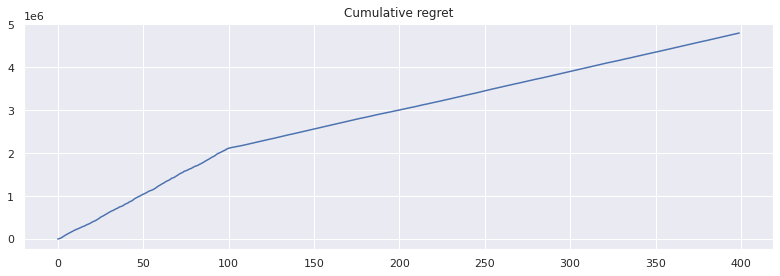

In [43]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('neural_ucb_linear.pdf')

Text(0.5, 1.0, 'reward')

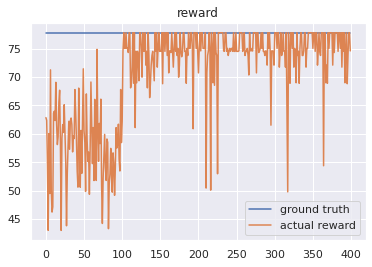

In [46]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'infeasibility')

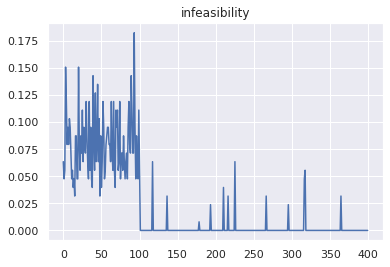

In [45]:
plt.plot(model.feasi)
plt.title('infeasibility')

Text(0.5, 1.0, 'reward')

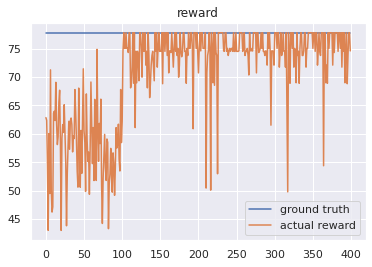

In [40]:
plt.plot([hwithoutconstraints(action)/(np.sqrt(args.card))]*T)
plt.plot(model.rewards_list)
plt.legend(['ground truth','actual reward'])
plt.title('reward')

Text(0.5, 1.0, 'infeasibility')

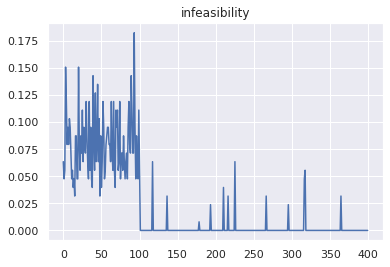

In [41]:
plt.plot(model.feasi)
plt.title('infeasibility')

In [42]:
hwithoutconstraints(action)/(np.sqrt(args.card))

77.81677523590568